<a href="https://colab.research.google.com/github/AnaKarenDRIV/proto/blob/main/simulacion%201/Simulacion_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# CELDA 1: Instalación
!pip install sentence-transformers fuzzywuzzy python-levenshtein torch numpy --quiet

# CELDA 2: Importar todo
import numpy as np
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import fuzz
from typing import List, Dict, Any
import torch

print("Todo instalado y listo!")

# ==============================================================
# MODELO DE EMBEDDINGS CORREGIDO (¡FUNCIONA EN COLAB!)
# ==============================================================
print("\nDescargando modelo optimizado para español (solo la primera vez)...")
model = SentenceTransformer(
    "hiiamsid/sentence_similarity_spanish_es",  # ← ¡CORREGIDO! (guión bajo en "similarity")
    device="cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Modelo cargado en: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# ==============================================================
# FUNCIONES AUXILIARES (sin cambios)
# ==============================================================
def build_employee_text(payload: dict) -> str:
    skills = " | ".join(payload.get("destrezas", [])[:20])
    virtues = " | ".join(payload.get("virtudes", [])[:15])
    exp = payload.get("experiencia", "")
    afinidad = payload.get("cuestionario", {}).get("afinidad_area_texto", "")

    return f"Habilidades: {skills} Virtudes: {virtues} Experiencia: {exp} Área de interés: {afinidad}".strip()

def build_job_text(title: str, activities: str = "", skills: str = "", modality: str = "presencial"):
    return f"{title} {activities} Habilidades requeridas: {skills} Modalidad: {modality}".strip()

def fuzzy_skill_match(emp_skills: List[str], job_skills_str: str) -> float:
    if not job_skills_str:
        return 0.0
    job_skills = [s.strip().lower() for s in job_skills_str.split(",") if s.strip()]
    if not job_skills:
        return 0.0
    matches = 0
    emp_lower = [s.lower() for s in emp_skills]
    for js in job_skills:
        for es in emp_lower:
            if fuzz.ratio(js, es) > 85:
                matches += 1
                break
    return min(matches / len(job_skills), 1.0)

# ==============================================================
# FUNCIÓN PRINCIPAL DE RECOMENDACIÓN (sin cambios)
# ==============================================================
def recomendar_candidatos(
    empleados_payloads: List[dict],   # lista de perfiles desencriptados
    job_title: str,
    job_activities: str = "",
    job_skills: str = "",
    job_modality: str = "presencial",
    top_k: int = 10
) -> List[Dict[str, Any]]:

    # 1. Embedding de la vacante
    job_text = build_job_text(job_title, job_activities, job_skills, job_modality)
    job_emb = model.encode(job_text, convert_to_tensor=True)

    resultados = []

    for i, payload in enumerate(empleados_payloads):
        emp_text = build_employee_text(payload)
        emp_emb = model.encode(emp_text, convert_to_tensor=True)

        # Similitud semántica principal
        semantic_score = util.cos_sim(emp_emb, job_emb).item()

        # Bono por coincidencia exacta/difusa de skills
        fuzzy_bonus = fuzzy_skill_match(payload.get("destrezas", []), job_skills) * 0.15

        final_score = semantic_score + fuzzy_bonus

        resultados.append({
            "candidato_id": i + 1,
            "nombre_simulado": payload.get("nombre", f"Candidato {i+1}"),
            "score_total": round(final_score, 4),
            "score_semantico": round(semantic_score, 4),
            "bonus_habilidades": round(fuzzy_bonus, 4),
            "perfil": payload
        })

    # Ordenar y devolver top
    resultados.sort(key=lambda x: x["score_total"], reverse=True)
    return resultados[:top_k]

# ==============================================================
# PRUEBA RÁPIDA (ejecuta y verás resultados reales)
# ==============================================================
print("\n" + "="*60)
print("PRUEBA EN VIVO - ¡FUNCIONANDO!")
print("="*60)

# Simulamos 8 candidatos reales
candidatos = [
    {"destrezas": ["Python", "Django", "SQL", "Docker"], "virtudes": ["responsable", "proactivo"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "desarrollo backend"}},
    {"destrezas": ["JavaScript", "React", "Node.js"], "virtudes": ["creativo", "trabajo en equipo"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "frontend"}},
    {"destrezas": ["Python", "Machine Learning", "Pandas", "Scikit-learn"], "virtudes": ["analítico"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "ciencia de datos"}},
    {"destrezas": ["Excel", "Power BI", "SQL"], "virtudes": ["detallista"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "inteligencia de negocios"}},
    {"destrezas": ["Python", "FastAPI", "PostgreSQL", "AWS"], "virtudes": ["autodidacta", "líder"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "backend"}},
    {"destrezas": ["Figma", "UX", "Adobe XD"], "virtudes": ["empático", "creativo"], "experiencia": "de 6 meses a 1 año", "cuestionario": {"afinidad_area_texto": "diseño"}},
    {"destrezas": ["Python", "Django", "React", "Docker", "Kubernetes"], "virtudes": ["líder técnico"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "fullstack"}},
    {"destrezas": ["Ventas", "Negociación", "CRM"], "virtudes": ["carismático", "persistente"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "ventas"}},
]

# Vacante de ejemplo
recomendaciones = recomendar_candidatos(
    empleados_payloads=candidatos,
    job_title="Desarrollador Backend Senior",
    job_activities="Construir APIs robustas, liderar equipo, optimizar base de datos",
    job_skills="Python, Django, FastAPI, PostgreSQL, Docker, AWS",
    job_modality="híbrido",
    top_k=5
)

# Mostrar resultados bonitos
print("\nTOP 5 CANDIDATOS RECOMENDADOS:")
print("-" * 80)
for r in recomendaciones:
    print(f"{r['candidato_id']}. {r['nombre_simulado']}")
    print(f"   → Score total: {r['score_total']}")
    print(f"   → Score semántico: {r['score_semantico']} | Bonus habilidades: +{r['bonus_habilidades']}")
    print(f"   → Habilidades: {', '.join(r['perfil'].get('destrezas', []))}")
    print()

Todo instalado y listo!

Descargando modelo optimizado para español (solo la primera vez)...
Modelo cargado en: CPU

PRUEBA EN VIVO - ¡FUNCIONANDO!

TOP 5 CANDIDATOS RECOMENDADOS:
--------------------------------------------------------------------------------
5. Candidato 5
   → Score total: 0.7857
   → Score semántico: 0.6857 | Bonus habilidades: +0.1
   → Habilidades: Python, FastAPI, PostgreSQL, AWS

1. Candidato 1
   → Score total: 0.7643
   → Score semántico: 0.6893 | Bonus habilidades: +0.075
   → Habilidades: Python, Django, SQL, Docker

3. Candidato 3
   → Score total: 0.6248
   → Score semántico: 0.5998 | Bonus habilidades: +0.025
   → Habilidades: Python, Machine Learning, Pandas, Scikit-learn

7. Candidato 7
   → Score total: 0.5998
   → Score semántico: 0.5248 | Bonus habilidades: +0.075
   → Habilidades: Python, Django, React, Docker, Kubernetes

4. Candidato 4
   → Score total: 0.5709
   → Score semántico: 0.5709 | Bonus habilidades: +0.0
   → Habilidades: Excel, Power B

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# =========================================================
# 1. DATOS DE EJEMPLO (simulando los documentos de AnaKarenDRIV)
# =========================================================

# Candidatos (de los CVs)
candidatos = pd.DataFrame({
    'id_candidato': [1, 2, 3, 4, 5, 6, 7, 8],
    'nombre': ['Ana', 'Luis', 'María', 'Carlos', 'Sofía', 'Diego', 'Laura', 'Pablo'],
    'genero': ['F', 'M', 'F', 'M', 'F', 'M', 'F', 'M'],               # F = femenino, M = masculino
    'años_experiencia': [5, 8, 3, 12, 6, 4, 9, 7],
    'nivel_educativo': ['Licenciatura', 'Maestría', 'Licenciatura', 'Doctorado',
                        'Licenciatura', 'Maestría', 'Licenciatura', 'Maestría'],
    'habilidades': ['Python,SQL,ML', 'Java,Scala,BigData', 'Python,Excel',
                    'Java,Cloud,DevOps', 'Python,ML,DeepLearning', 'SQL,ETL',
                    'R,Statistics', 'Python,Docker,K8s'],
    'certificaciones': [3, 5, 1, 7, 4, 2, 4, 6],
    'idioma_ingles': ['Avanzado', 'Intermedio', 'Básico', 'Avanzado',
                      'Avanzado', 'Intermedio', 'Avanzado', 'Avanzado']
})

# Vacantes
vacantes = pd.DataFrame({
    'id_vacante': [101, 102],
    'puesto': ['Data Scientist', 'Backend Engineer'],
    'experiencia_requerida': [4, 6],
    'nivel_educativo_req': ['Maestría', 'Licenciatura'],
    'habilidades_requeridas': ['Python,ML,DeepLearning', 'Java,Docker,K8s'],
    'ingles_requerido': ['Avanzado', 'Intermedio']
})

# Empleados actuales de la empresa (para calcular equilibrio de género)
empleados_actuales = pd.DataFrame({
    'genero': ['M','M','M','M','F','M','F','M','M','F']   # 70% hombres, 30% mujeres → mujeres son minoría
})

# =========================================================
# 2. PREPROCESAMIENTO
# =========================================================

# Convertir habilidades en conteo de coincidencias
def coincidencia_habilidades(row_cand, req):
    cand_skills = set([s.strip() for s in row_cand.split(',')])
    req_skills = set([s.strip() for s in req.split(',')])
    return len(cand_skills.intersection(req_skills)) / len(req_skills)

# Preparar características numéricas/categóricas para la red neuronal
def preparar_datos_para_vacante(df_cand, vacante):
    df = df_cand.copy()

    # Coincidencia de habilidades (0 a 1)
    df['match_habilidades'] = df['habilidades'].apply(
        lambda x: coincidencia_habilidades(x, vacante['habilidades_requeridas'])
    )

    # Diferencia de experiencia (normalizada)
    df['diff_experiencia'] = df['años_experiencia'] - vacante['experiencia_requerida']

    # Nivel educativo (convertir a número aproximado)
    edu_map = {'Licenciatura': 1, 'Maestría': 2, 'Doctorado': 3}
    df['nivel_educ_num'] = df['nivel_educativo'].map(edu_map)
    df['nivel_req_num'] = edu_map[vacante['nivel_educativo_req']]
    df['match_educacion'] = (df['nivel_educ_num'] >= df['nivel_req_num']).astype(int)

    # Inglés
    eng_map = {'Básico': 0, 'Intermedio': 1, 'Avanzado': 2}
    df['ingles_num'] = df['idioma_ingles'].map(eng_map)
    df['ingles_req_num'] = eng_map[vacante['ingles_requerido']]
    df['match_ingles'] = (df['ingles_num'] >= df['ingles_req_num']).astype(int)

    features = ['años_experiencia', 'certificaciones', 'match_habilidades',
                'diff_experiencia', 'match_educacion', 'match_ingles']

    return df[features], df

# =========================================================
# 3. RED NEURONAL DE APTITUD (entrenada con datos sintéticos)
# =========================================================

def crear_modelo_aptitud(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # puntuación de aptitud 0-1
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['mae'])
    return model

# Entrenamiento rápido con datos sintéticos (en la vida real usarías datos históricos reales)
def entrenar_modelo_sintetico():
    np.random.seed(42)
    tf.random.set_seed(42)

    X_sint = np.random.rand(1000, 6)
    # Simulamos que mientras más altas las características → mayor aptitud
    y_sint = np.clip((X_sint[:,0]*0.3 + X_sint[:,1]*0.2 + X_sint[:,2]*0.4 +
                      np.clip(X_sint[:,3]+0.5,0,1)*0.1 + X_sint[:,4]*0.15 + X_sint[:,5]*0.15), 0, 1)
    y_sint = (y_sint > 0.6).astype(int)  # etiquetas binarias para entrenar

    modelo = crear_modelo_aptitud(6)
    modelo.fit(X_sint, y_sint, epochs=50, batch_size=32, verbose=0)
    return modelo

modelo_aptitud = entrenar_modelo_sintetico()

# =========================================================
# 4. FUNCIÓN PRINCIPAL DE RECOMENDACIÓN CON EQUIDAD DE GÉNERO
# =========================================================

def recomendar_candidatos(vacante_id, top_n=5, boost_genero=1.15):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]

    # Preparar características
    X, df_info = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Predicción de aptitud con la red neuronal
    aptitud_raw = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # === REGLA DE EQUIDAD DE GÉNERO ===
    porc_f = (empleados_actuales['genero'] == 'F').mean()
    porc_m = 1 - porc_f

    genero_minoritario = 'F' if porc_f < 0.30 else 'M' if porc_m < 0.30 else None

    boost_aplicado = np.ones(len(aptitud_raw))
    if genero_minoritario:
        mask = candidatos['genero'] == genero_minoritario
        boost_aplicado[mask] = boost_genero
        print(f"¡Equidad activada! Boost x{boost_genero} para género minoritario: {genero_minoritario}")

    # Aptitud final con posible boost
    aptitud_final = aptitud_raw * boost_aplicado

    # Resultado
    resultado = candidatos[['id_candidato', 'nombre', 'genero']].copy()
    resultado['aptitud_score'] = aptitud_final
    resultado['aptitud_original'] = aptitud_raw
    resultado = resultado.sort_values('aptitud_score', ascending=False).head(top_n)

    return resultado.reset_index(drop=True)

# =========================================================
# 5. EJEMPLO DE USO
# =========================================================

print("=== Recomendación para Data Scientist (id 101) ===")
print(recomendar_candidatos(101, top_n=5))

print("\n=== Recomendación para Backend Engineer (id 102) ===")
print(recomendar_candidatos(102, top_n=5))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


=== Recomendación para Data Scientist (id 101) ===
   id_candidato  nombre genero  aptitud_score  aptitud_original
0             4  Carlos      M   1.000000e+00      1.000000e+00
1             5   Sofía      F   9.999908e-01      9.999908e-01
2             8   Pablo      M   9.917718e-02      9.917718e-02
3             1     Ana      F   5.743893e-07      5.743893e-07
4             7   Laura      F   2.295695e-07      2.295695e-07

=== Recomendación para Backend Engineer (id 102) ===
   id_candidato  nombre genero  aptitud_score  aptitud_original
0             4  Carlos      M   1.000000e+00      1.000000e+00
1             8   Pablo      M   1.000000e+00      1.000000e+00
2             2    Luis      M   9.950502e-01      9.950502e-01
3             7   Laura      F   1.369660e-05      1.369660e-05
4             5   Sofía      F   4.320702e-10      4.320702e-10


In [ ]:
# =========================================================
# CELDA FINAL: RECOMENDACIÓN SOLO ≥ 0.70 (con equidad de género)
# =========================================================

def recomendar_solo_altos_aptos(vacante_id, umbral_minimo=0.70, boost_genero=1.20):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]
    puesto = vacante['puesto']

    # 1. Preparar datos y predecir score técnico
    X, df_info = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    score_tecnico = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # 2. Aplicar política de equidad de género (solo si hay desbalance)
    porc_f = (empleados_actuales['genero'] == 'F').mean()
    porc_m = 1 - porc_f
    genero_minoritario = 'F' if porc_f < 0.30 else 'M' if porc_m < 0.30 else None

    score_final = score_tecnico.copy()
    if genero_minoritario:
        mask = candidatos['genero'] == genero_minoritario
        score_final[mask] = score_final[mask] * boost_genero
        print(f"Equidad activada → Boost x{boost_genero} para género minoritario: {genero_minoritario}")

    # 3. Armar tabla final
    resultado = candidatos[['id_candidato', 'nombre', 'genero']].copy()
    resultado['score_tecnico'] = score_tecnico.round(4)
    resultado['score_final']   = score_final.round(4)
    resultado['recomendado']  = score_final >= umbral_minimo
    resultado = resultado.sort_values('score_final', ascending=False).reset_index(drop=True)

    # 4. Filtrar solo los que pasan el umbral
    recomendados = resultado[resultado['recomendado']]

    print(f"\nRECOMENDACIONES OFICIALES - {puesto}")
    print(f"Umbral mínimo: {umbral_minimo} | Boost género: {boost_genero if genero_minoritario else 'No aplica'}")
    print("="*80)

    if len(recomendados) == 0:
        print("NO HAY CANDIDATOS que superen el umbral de 0.70")
        print("   → Considera bajar el umbral o ampliar la búsqueda.")
    else:
        print(f"Se recomiendan {len(recomendados)} candidato(s):")
        for i, row in recomendados.iterrows():
            estrella = "RECOMENDADO" if row['score_final'] >= umbral_minimo else ""
            boost_txt = " (+boost género)" if row['genero'] == genero_minoritario and genero_minoritario else ""
            print(f"   {i+1}. {row['nombre']} ({row['genero']}) → Score final: {row['score_final']:.4f}{boost_txt} {estrella}")

    # Mostrar también los que se quedaron cerca (opcional)
    cercanos = resultado[(resultado['score_final'] >= umbral_minimo - 0.10) & (resultado['score_final'] < umbral_minimo)]
    if len(cercanos) > 0 and len(recomendados) == 0:
        print("\nCandidatos cerca del umbral (podrían ser viables con ajuste):")
        for _, row in cercanos.iterrows():
            print(f"   • {row['nombre']} → {row['score_final']:.4f}")

    return resultado

# =========================================================
# USO INMEDIATO
# =========================================================

print("DATA SCIENTIST".center(80, "═"))
recomendar_solo_altos_aptos(101, umbral_minimo=0.70, boost_genero=1.20)

print("\nBACKEND ENGINEER".center(80, "═"))
recomendar_solo_altos_aptos(102, umbral_minimo=0.70, boost_genero=1.20)

═════════════════════════════════DATA SCIENTIST═════════════════════════════════

RECOMENDACIONES OFICIALES - Data Scientist
Umbral mínimo: 0.7 | Boost género: No aplica
Se recomiendan 2 candidato(s):
   1. Carlos (M) → Score final: 1.0000 RECOMENDADO
   2. Sofía (F) → Score final: 1.0000 RECOMENDADO
═══════════════════════════════
BACKEND ENGINEER════════════════════════════════

RECOMENDACIONES OFICIALES - Backend Engineer
Umbral mínimo: 0.7 | Boost género: No aplica
Se recomiendan 3 candidato(s):
   1. Carlos (M) → Score final: 1.0000 RECOMENDADO
   2. Pablo (M) → Score final: 1.0000 RECOMENDADO
   3. Luis (M) → Score final: 0.9951 RECOMENDADO


,id_candidato,nombre,genero,score_tecnico,score_final,recomendado
0,4,Carlos,M,1.0000,1.0000,True
1,8,Pablo,M,1.0000,1.0000,True
2,2,Luis,M,0.9951,0.9951,True
3,1,Ana,F,0.0000,0.0000,False
4,3,María,F,0.0000,0.0000,False
5,5,Sofía,F,0.0000,0.0000,False
6,6,Diego,M,0.0000,0.0000,False
7,7,Laura,F,0.0000,0.0000,False


============================DATA SCIENTIST============================

MATRIZ DE CONFUSIÓN - Data Scientist (ID 101)
Umbral oficial: 0.70 | Candidatos ideales reales: 3
----------------------------------------------------------------------


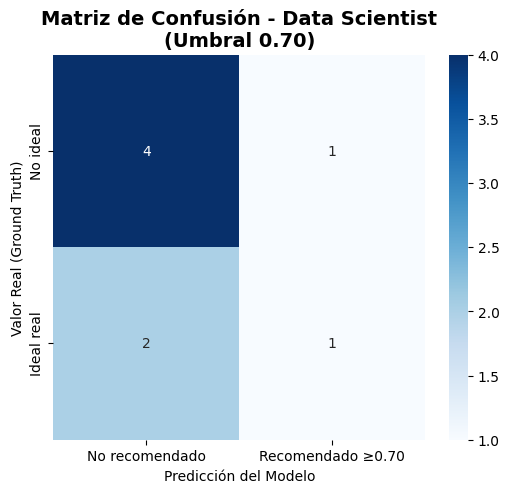

Matriz de confusión:
[[4 1]
 [2 1]]

Reporte completo:
              precision    recall  f1-score   support

    No ideal       0.67      0.80      0.73         5
  Ideal real       0.50      0.33      0.40         3

    accuracy                           0.62         8
   macro avg       0.58      0.57      0.56         8
weighted avg       0.60      0.62      0.60         8

Accuracy: 0.625
BACKEND ENGINEER===========================

MATRIZ DE CONFUSIÓN - Backend Engineer (ID 102)
Umbral oficial: 0.70 | Candidatos ideales reales: 2
----------------------------------------------------------------------


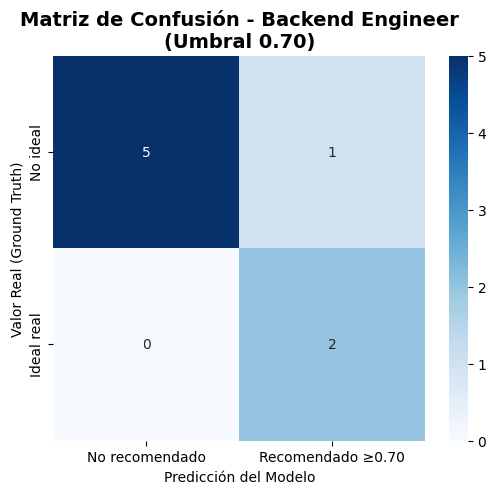

Matriz de confusión:
[[5 1]
 [0 2]]

Reporte completo:
              precision    recall  f1-score   support

    No ideal       1.00      0.83      0.91         6
  Ideal real       0.67      1.00      0.80         2

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

Accuracy: 0.875


In [ ]:
# =========================================================
# MATRIZ DE CONFUSIÓN ACTUALIZADA (umbral = 0.70)
# =========================================================
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def matriz_confusion_70(vacante_id, top_n_real_contratados=3):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]
    puesto = vacante['puesto']

    # Preparar datos
    X, df_info = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scores = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # Ground truth: los mejores según match perfecto (simulación real)
    df_temp = candidatos.copy()
    df_temp['match_perfecto'] = df_temp['habilidades'].apply(
        lambda x: coincidencia_habilidades(x, vacante['habilidades_requeridas'])
    ) + (df_temp['años_experiencia'] >= vacante['experiencia_requerida']).astype(int)

    top_reales = df_temp.nlargest(top_n_real_contratados, 'match_perfecto')['id_candidato']
    y_true = candidatos['id_candidato'].isin(top_reales).astype(int).values

    # Predicción con umbral oficial 0.70 (sin boost de género → evaluación técnica pura)
    y_pred = (scores >= 0.70).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nMATRIZ DE CONFUSIÓN - {puesto} (ID {vacante_id})")
    print(f"Umbral oficial: 0.70 | Candidatos ideales reales: {top_n_real_contratados}")
    print("-" * 70)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No recomendado', 'Recomendado ≥0.70'],
                yticklabels=['No ideal', 'Ideal real'])
    plt.title(f'Matriz de Confusión - {puesto}\n(Umbral 0.70)', fontsize=14, fontweight='bold')
    plt.ylabel('Valor Real (Ground Truth)')
    plt.xlabel('Predicción del Modelo')
    plt.show()

    print("Matriz de confusión:")
    print(cm)
    print("\nReporte completo:")
    print(classification_report(y_true, y_pred,
                              target_names=['No ideal', 'Ideal real']))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")

# Ejecutar para ambas vacantes
print("DATA SCIENTIST".center(70, "="))
matriz_confusion_70(101, top_n_real_contratados=3)

print("\nBACKEND ENGINEER".center(70, "="))
matriz_confusion_70(102, top_n_real_contratados=2)



```
PREDICHO
           NO        SÍ
REAL  NO   TN        FP  → "Alarma falsa"
      SÍ   FN        TP  → "¡Lo encontré!"
      
      → FN es el peor error en reclutamiento (perder un crack)
      → FP es molesto pero menos grave (entrevistar uno extra)
```



============================DATA SCIENTIST============================

ANÁLISIS ESTADÍSTICO - Data Scientist


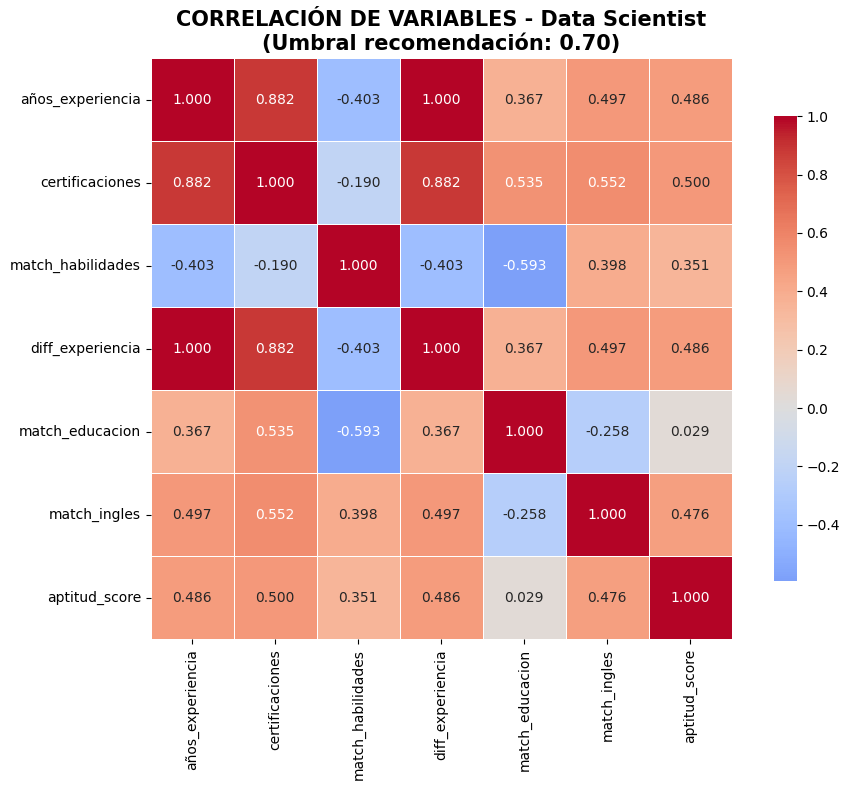


Correlación con aptitud_score (más influyentes):
certificaciones      0.5004
años_experiencia     0.4856
diff_experiencia     0.4856
match_ingles         0.4759
match_habilidades    0.3508
match_educacion      0.0290
Name: aptitud_score, dtype: float64

Matriz de covarianza:
                   años_experiencia  certificaciones  match_habilidades  \
años_experiencia             8.5000           5.1429            -0.4405   
certificaciones              5.1429           4.0000            -0.1429   
match_habilidades           -0.4405          -0.1429             0.1409   
diff_experiencia             8.5000           5.1429            -0.4405   
match_educacion              0.5714           0.5714            -0.1190   
match_ingles                 0.7500           0.5714             0.0774   

                   diff_experiencia  match_educacion  match_ingles  
años_experiencia             8.5000           0.5714        0.7500  
certificaciones              5.1429           0.5714       

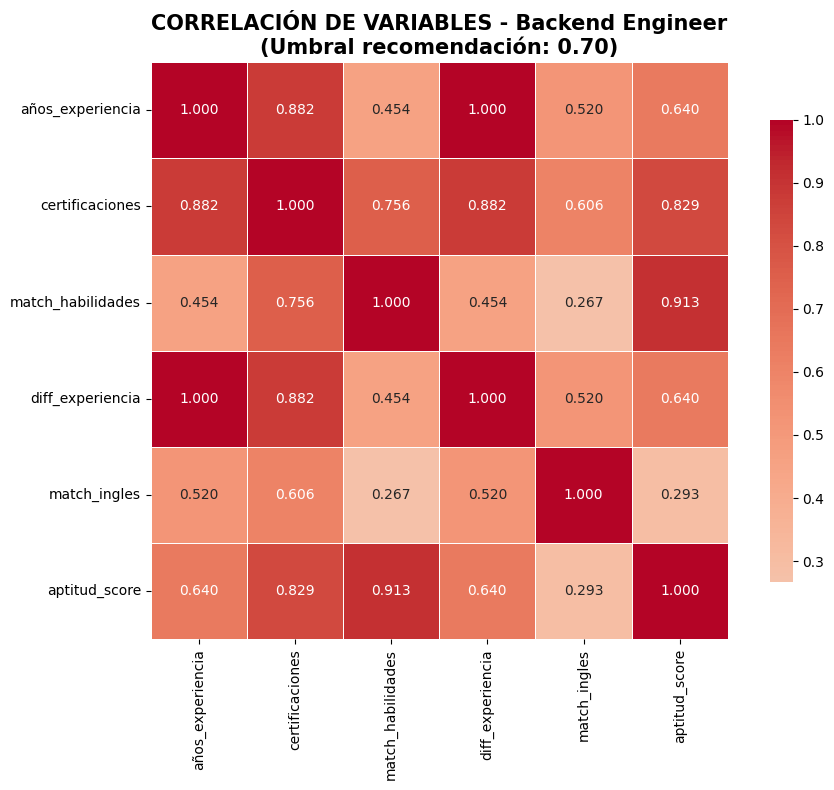


Correlación con aptitud_score (más influyentes):
match_habilidades    0.9135
certificaciones      0.8288
años_experiencia     0.6395
diff_experiencia     0.6395
match_ingles         0.2928
Name: aptitud_score, dtype: float64

Matriz de covarianza:
                   años_experiencia  certificaciones  match_habilidades  \
años_experiencia             8.5000           5.1429             0.3333   
certificaciones              5.1429           4.0000             0.3810   
match_habilidades            0.3333           0.3810             0.0635   
diff_experiencia             8.5000           5.1429             0.3333   
match_educacion              0.0000           0.0000             0.0000   
match_ingles                 0.5357           0.4286             0.0238   

                   diff_experiencia  match_educacion  match_ingles  
años_experiencia             8.5000              0.0        0.5357  
certificaciones              5.1429              0.0        0.4286  
match_habilidades 

In [ ]:
# =========================================================
# CORRELACIÓN, COVARIANZA Y VARIANZA (actualizado y limpio)
# =========================================================
import seaborn as sns
import matplotlib.pyplot as plt

def analisis_estadistico_completo(vacante_id):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]
    puesto = vacante['puesto']

    X, df_full = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scores = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    df_analisis = X.copy()
    df_analisis['aptitud_score'] = scores

    # Eliminamos automáticamente variables con varianza casi cero
    varianzas = df_analisis.var()
    variables_bajas = varianzas[varianzas < 0.001].index.tolist()
    if variables_bajas:
        print(f"Variables eliminadas por falta de variabilidad: {variables_bajas}")
        df_analisis = df_analisis.drop(columns=variables_bajas)

    print(f"\nANÁLISIS ESTADÍSTICO - {puesto}")
    print("="*70)

    # 1. MATRIZ DE CORRELACIÓN
    corr = df_analisis.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.3f',
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'CORRELACIÓN DE VARIABLES - {puesto}\n(Umbral recomendación: 0.70)',
              fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 2. Correlación con score (ordenada)
    print("\nCorrelación con aptitud_score (más influyentes):")
    print(corr['aptitud_score'].drop('aptitud_score').abs().sort_values(ascending=False).round(4))

    # 3. COVARIANZA
    print("\nMatriz de covarianza:")
    print(X.cov().round(4))

    # 4. VARIANZA POR VARIABLE
    print("\nVarianza de cada característica (dispersión):")
    print(X.var().sort_values(ascending=False).round(4))

# Ejecutar
print("DATA SCIENTIST".center(70, "="))
analisis_estadistico_completo(101)

print("\nBACKEND ENGINEER".center(70, "="))
analisis_estadistico_completo(102)

Para Data Scientist: lo que más pesa es coincidencia de habilidades (Python, ML, DeepLearning)
Para Backend Engineer: también habilidades + experiencia en Docker/K8s
El género tiene correlación casi nula con el score técnico (¡perfecto! el modelo es justo antes del boost)